In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import constants as cst
from astropy import units as u
import healpy as hp

from aqn import *
from constants import *
from survey_parameters import *
from skymap_plotting_functions import *
from aqn_simulation import *


Loaded constants script
Loaded AQN script
Loaded survey parameters script


In [2]:
def plot_cube(x, unit_label, save_name):
    resolution = np.shape(x)[0]
    voxel_centers = np.reshape(grid_coords, (resolution, resolution, resolution, 3))[0][:,0,0]
    voxel_centers = np.array([voxel_centers, voxel_centers, voxel_centers])
    z_slice_min, z_slice_max = [-0.5,0.5]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(x[:,:,mask], axis=2).value
    # slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
    plt.figure(dpi=500)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(unit_label, fontsize=20)
    plt.xlabel('$x$ [kpc]', size=20)
    plt.ylabel('$y$ [kpc]', size=20)
    plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
    plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)
    
    plt.title("T_AQN", size=20)
    
    # plt.savefig(save_name+".png", bbox_inches='tight')
    # plt.savefig(save_name+".svg", bbox_inches='tight')
    
    # plt.close()
    plt.show()

In [3]:
# define AQN parameters
m_aqn_kg = 0.05*u.kg
R_aqn_cm = calc_R_AQN(m_aqn_kg)

print("using m_aqn =", m_aqn_kg)
print("using R_aqn =", R_aqn_cm)

using m_aqn = 0.05 kg
using R_aqn = 3.2429315622338985e-05 cm


In [5]:
# import cubes and grid_coords
grid_coords = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load("../data/FIRE/grid-ids---dark_mat.npy")

cubes = {}
cubes["dark_mat"] = np.load("../data/FIRE/cubes/cube-dark_mat_density.npy") * u.kg/u.m**3
cubes["ioni_gas"] = np.load("../data/FIRE/cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
cubes["neut_gas"] = np.load("../data/FIRE/cubes/cube-neut_gas_density.npy") * u.kg/u.m**3
cubes["temp_ion"] = np.load("../data/FIRE/cubes/cube-ioni_gas_temp.npy") * u.K
cubes["dv_ioni"]  = np.load("../data/FIRE/cubes/cube-dv_ioni.npy") * u.m/u.s
cubes["dv_neut"]  = np.load("../data/FIRE/cubes/cube-dv_neut.npy") * u.m/u.s

# # compute distance from every grid centre to galactic centre
distances = np.sqrt(np.sum(grid_coords**2, axis=1)) * u.kpc

In [6]:
# perform some unit conversions
cubes["ioni_gas"] = (cubes["ioni_gas"]/cst.m_p.si).to(1/u.cm**3)
cubes["neut_gas"] = (cubes["neut_gas"]/cst.m_p.si).to(1/u.cm**3)
cubes["dark_mat"] = (cubes["dark_mat"]/  m_aqn_kg).to(1/u.cm**3)
cubes["temp_ion"] =  cubes["temp_ion"]*K_to_eV
cubes["dv_ioni"]  =  cubes["dv_ioni"] /cst.c
cubes["dv_neut"]  =  cubes["dv_neut"] /cst.c

In [13]:
# compute T_AQN
cubes["t_aqn_n"] = T_AQN_analytical(cubes["neut_gas"], cubes["dv_neut"], f, g)
cubes["t_aqn_i"] = T_AQN_ionized2(cubes["ioni_gas"], cubes["dv_ioni"], f, g, cubes["temp_ion"], R_aqn_cm)
# if ioni temp is lower than neut temp, replace with neut temp
cubes["t_aqn_i"][cubes["t_aqn_i"]<cubes["t_aqn_n"]] = cubes["t_aqn_n"][cubes["t_aqn_i"]<cubes["t_aqn_n"]]

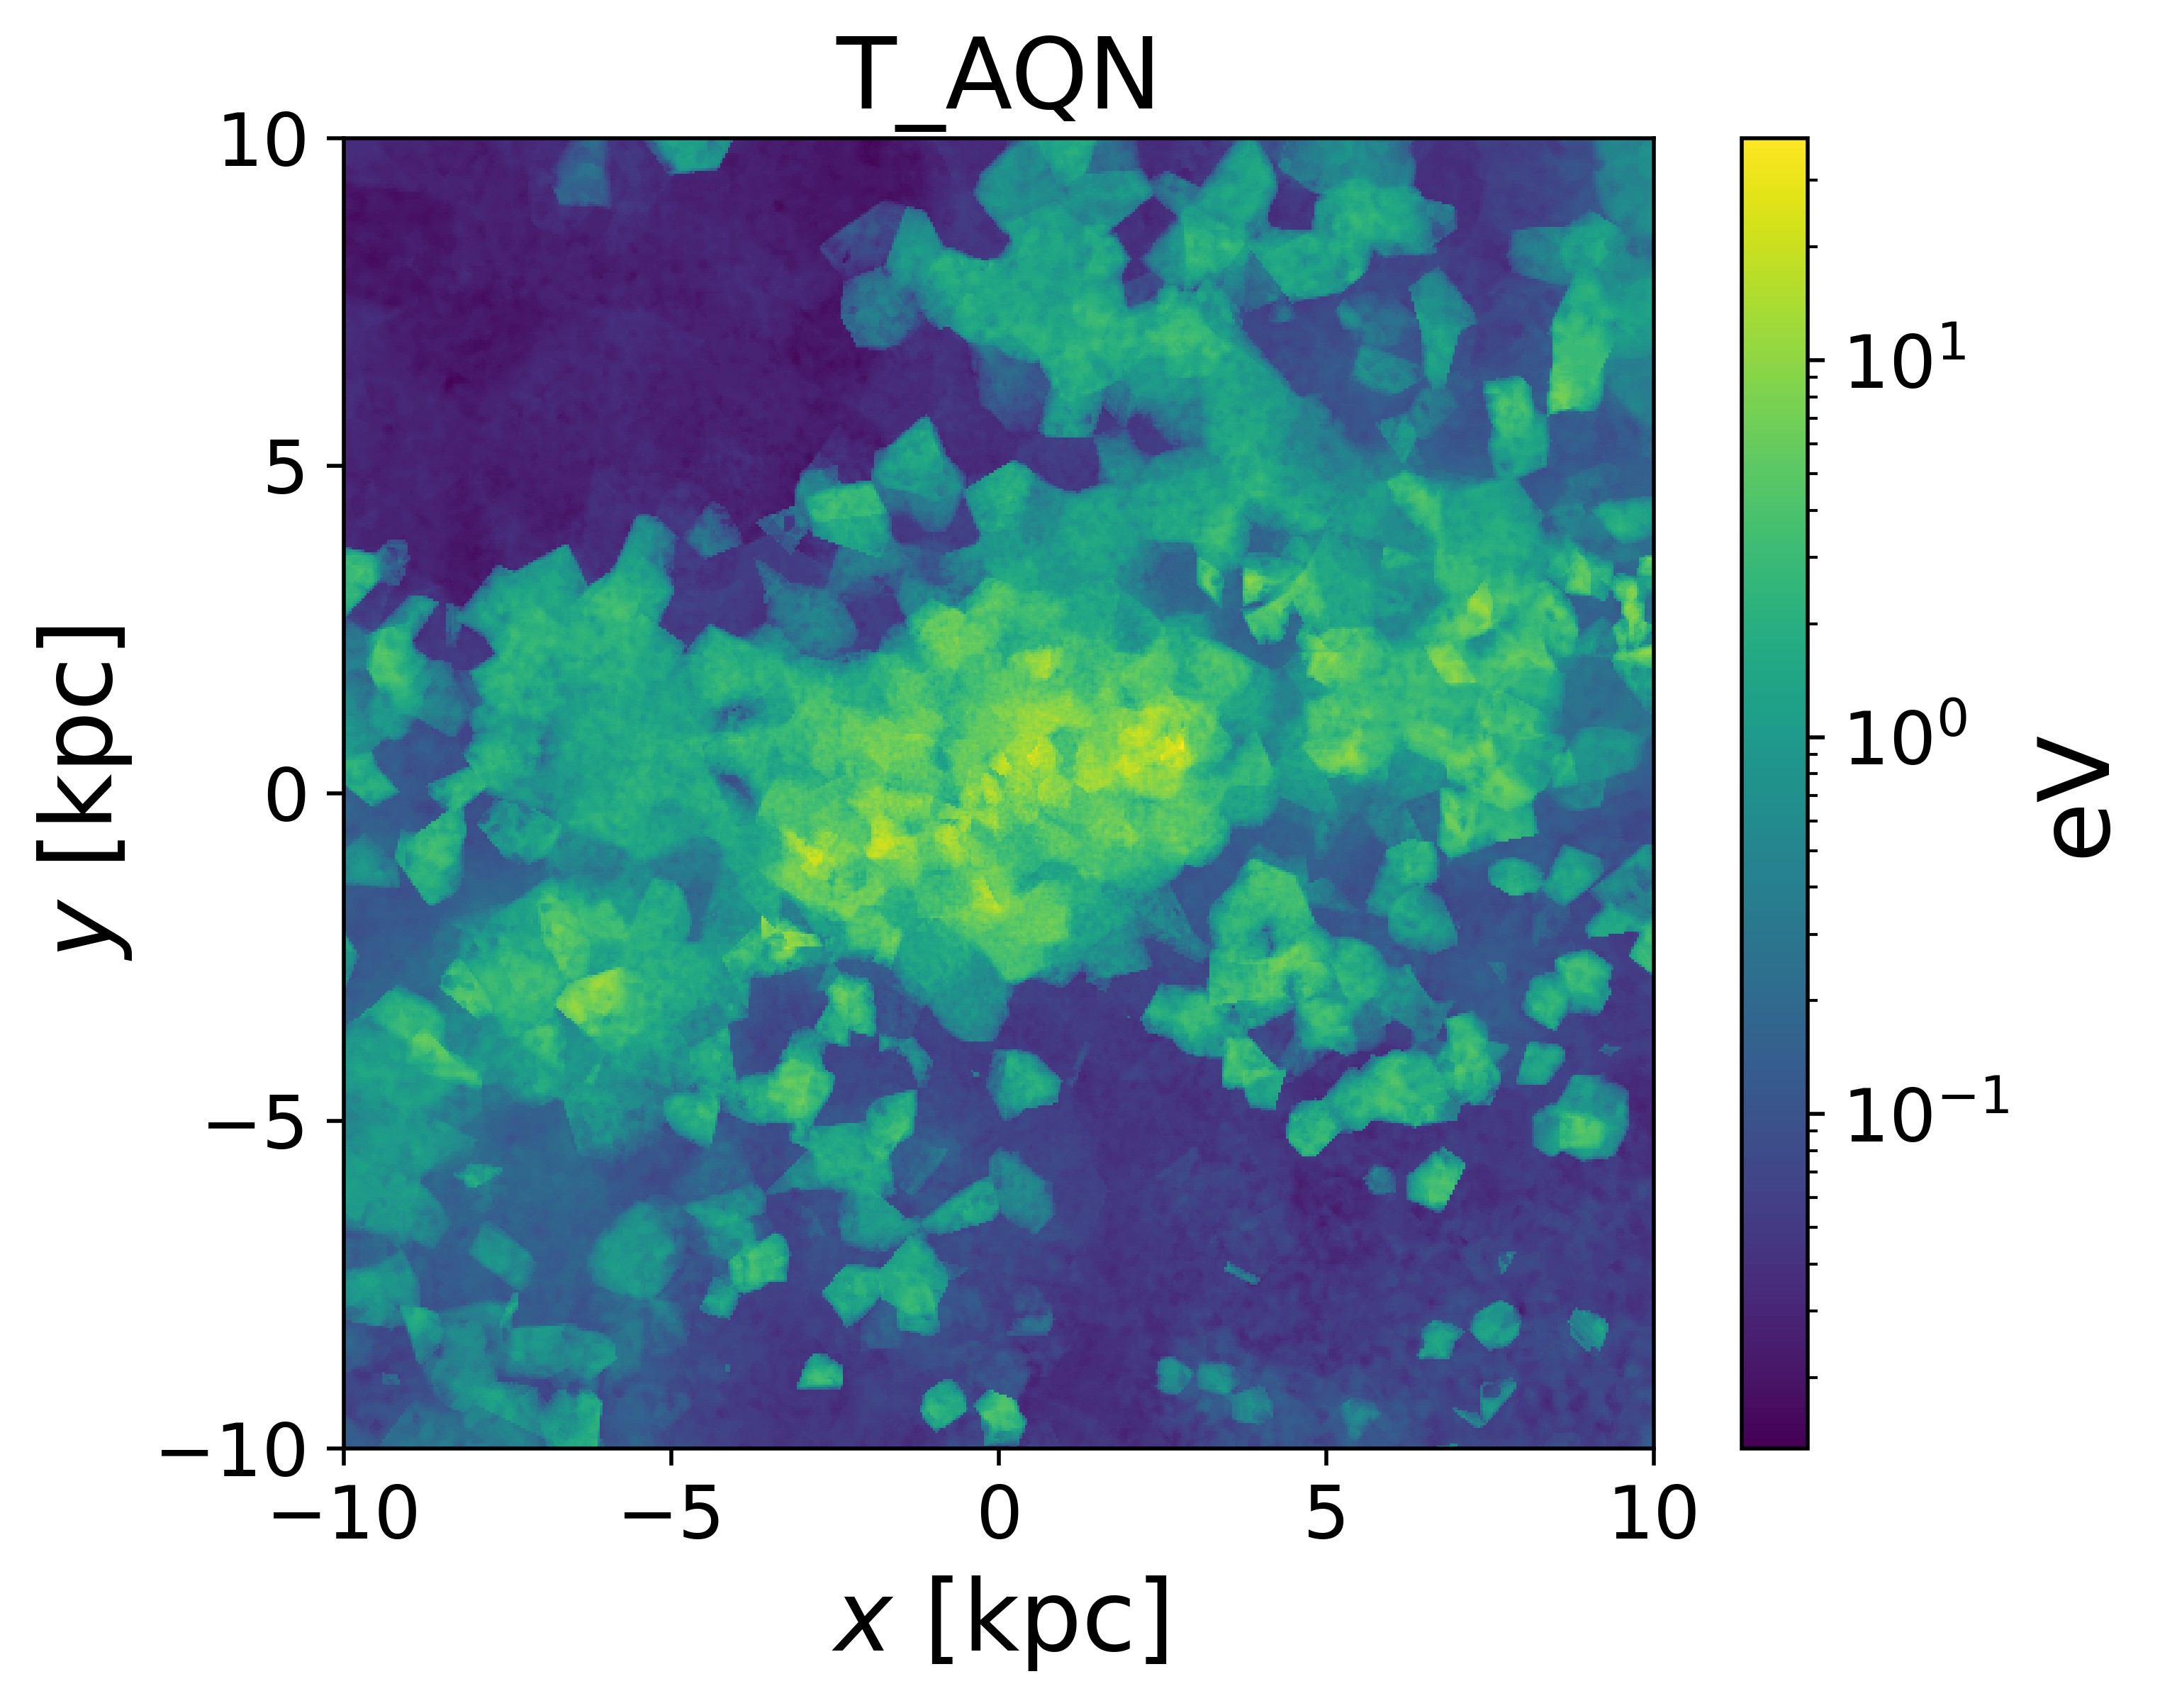

In [12]:
plot_cube(cubes["t_aqn_i"], "eV", "none")